## Import Libraries

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import json
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Visualize pass actions

- We will maybe not yet be able to give half-time advice but we will learn ways to visualise the data in the way that helps coaching staff understand the game better.


## Collecting Data

In [3]:
# Open the file and load its contents into a dictionary
with open('../data/StatsBomb/Data/ManCity_Arsenal_events.json', 'r') as f:
    data = json.load(f)

In [4]:
# Convert the list of JSON values to a DataFrame
df = pd.json_normalize(data)

In [5]:
teams_comp = list(df['team.name'].value_counts().keys())

## Preparing the data
For passing networks we use only accurate/successful passes made by a team until the first substitution.
This is mainly just to get going and there are several possible variations of this.
We need information about pass start and end location as well as player who made and received the pass. 
To make the vizualisation clearer, we annotate the players using their surname.
(This works for English women side, since players' surnames  are single-barrelled. But
can cause problems.For example, Leo Messi's name in Statsbomb is Lionel Andrés Messi Cuccittini. So the
name Cuccittini will come up if you run this code on his matches!).

In [21]:
def prepare_data_pass(df,team_name):
    #check for index of first sub
    sub = df.loc[df["type.name"] == "Substitution"].loc[df["team.name"] == team_name].iloc[0]["index"]

    #make df with successfull passes by Manchester City until the first substitution
    mask_mancity = (df['type.name'] == 'Pass')\
    & (df['team.name']==team_name) \
    & (df.index < sub) \
    &(df['substitution.replacement.name'].isnull())\
    &(~df['pass.recipient.name'].isnull())

    #taking necessary columns
    df_pass_details = df.loc[mask_mancity, ['location','pass.end_location','player.name','pass.recipient.name']]

    df_pass_details['x'] = [axes[0] for axes in df_pass_details['location'].values]
    df_pass_details['y'] = [axes[1] for axes in df_pass_details['location'].values]

    df_pass_details['end_x'] = [axes[0] for axes in df_pass_details['pass.end_location'].values]
    df_pass_details['end_y'] = [axes[1] for axes in df_pass_details['pass.end_location'].values]

    df_pass = df_pass_details[['x', 'y', 'end_x', 'end_y','player.name','pass.recipient.name']]

    #adjusting that only the surname of a player is presented.
    df_pass["player.name"] = df_pass["player.name"].apply(lambda x: str(x).split()[-1])
    df_pass["pass.recipient.name"] = df_pass["pass.recipient.name"].apply(lambda x: str(x).split()[-1])
    return df_pass

## Calculating vertices size and location
To calculate vertices size and location, first we create an empty dataframe.
For each player we calculate average location of passes made and receptions.
Then, we calculate number of passes made by each player.
As the last step, we calculate set he marker size to be proportional to number of passes.

In [7]:
def calculate_vertices(df_pass):
    scatter_df = pd.DataFrame()
    for i, name in enumerate(df_pass["player.name"].unique()):
        passx = df_pass.loc[df_pass["player.name"] == name]["x"].to_numpy()
        recx = df_pass.loc[df_pass["pass.recipient.name"] == name]["end_x"].to_numpy()
        passy = df_pass.loc[df_pass["player.name"] == name]["y"].to_numpy()
        recy = df_pass.loc[df_pass["pass.recipient.name"] == name]["end_y"].to_numpy()
        scatter_df.at[i, "player.name"] = name
        #make sure that x and y location for each circle representing the player is the average of passes and receptions
        scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
        scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))
        #calculate number of passes
        scatter_df.at[i, "no"] = df_pass.loc[df_pass["player.name"] == name].count().iloc[0]

    #adjust the size of a circle so that the player who made more passes 
    scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1500)
    return scatter_df

## Calculating edges width
To calculate edge width we again look at the number of passes between players
We need to group the dataframe of passes by the combination of passer and recipient and count passes between them.
As the last step, we set the threshold ignoring players that made fewer than 2 passes.
You can try different thresholds and investigate how the passing network changes when you change it.
It is recommended that you tune this depedning on the message behind your visualisation.

In [8]:
#counting passes between players
def calculate_edges_width(df_temp):
    df_pass = df_temp.copy()
    df_pass["pair_key"] = df_pass.apply(lambda x: "_".join(sorted([x["player.name"], x["pass.recipient.name"]])), axis=1)
    lines_df = df_pass.groupby(["pair_key"]).x.count().reset_index()
    lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)
    #setting a treshold. You can try to investigate how it changes when you change it.
    lines_df = lines_df[lines_df['pass_count']>2]
    scatter_df = calculate_vertices(df_pass)
    return df_pass,lines_df,scatter_df

## Passing Networks

- A passing network can really tell the story of a game
- **Get the real idea of formation of where the players are located on the pitch**
    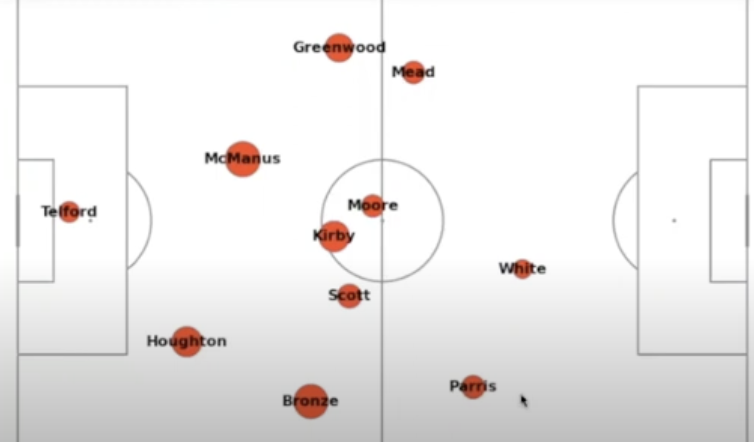
- Each point represents a player
- Thicker lines indicate a higher number of passes
- It’s immediately clear that Italy made a lot more successful passes than England
- Carroll managed to win the ball so many times from Hart’s kicks. Despite being on the pitch only half as long as most of the other players, he was one end of England’s most successful passing partnership
- But Hart and Carroll’s success reveals failures elsewhere. England had no consistent passing network in midfield. Instead, the Italians dominated the match, with 68% of possession and 36 shots. Italy passed the ball forward and England tried to kick it over their heads.
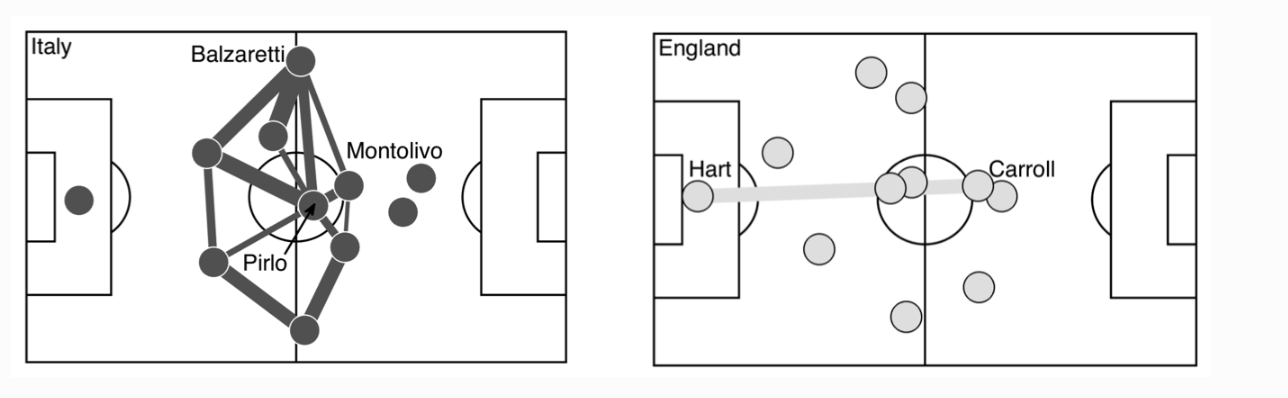

## Plotting edges
For each combination of players who made passes, we make a query to *scatter_df* to get the start and end of the line.
Then we adjust the line width so that the more passes between players, the wider the line.
As the next step, we plot the lines on the pitch. It is recommended that zorder of edges is lower than zorder of vertices.
In the end, we make the title.

In [15]:
#plot once again pitch and vertices
def plotting_edges(team_dict):
    # get the information regarding the passes between the home team     
    df_pass = team_dict['df_pass']
    lines_df = team_dict['lines_df']
    team_color = team_dict['color']
    team_name = team_dict['team_name']
    scatter_df = team_dict['scatter_df']
    
    pitch = Pitch(line_color='grey')
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                         endnote_height=0.04, title_space=0, endnote_space=0)
    pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color=team_color, edgecolors='grey', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)
    for i, row in scatter_df.iterrows():
        pitch.annotate(row['player.name'], xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=16, ax=ax["pitch"], zorder = 4)

    for i, row in lines_df.iterrows():
            player1 = row["pair_key"].split("_")[0]
            player2 = row['pair_key'].split("_")[1]
            #take the average location of players to plot a line between them 
            player1_x = scatter_df.loc[scatter_df["player.name"] == player1]['x'].iloc[0]
            player1_y = scatter_df.loc[scatter_df["player.name"] == player1]['y'].iloc[0]
            player2_x = scatter_df.loc[scatter_df["player.name"] == player2]['x'].iloc[0]
            player2_y = scatter_df.loc[scatter_df["player.name"] == player2]['y'].iloc[0]
            num_passes = row["pass_count"]
            #adjust the line width so that the more passes, the wider the line
            line_width = (num_passes / lines_df['pass_count'].max() * 10)
            #plot lines on the pitch
            pitch.lines(player1_x, player1_y, player2_x, player2_y,
                            alpha=1, lw=line_width, zorder=2, color=team_color, ax = ax["pitch"])

    fig.suptitle(f"{team_name} Passing Network", fontsize = 30)
    plt.show()

In [10]:
def plotting_edges_two_teams(home_dict, away_dict):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

    # get the information regarding the passes between the home team     
    df_pass_h = home_dict['df_pass']
    lines_df_h = home_dict['lines_df']
    team_color_h = home_dict['color']
    team_name_h = home_dict['team_name']
    scatter_df_h = home_dict['scatter_df']
    
    # plot first subplot
    pitch1 = Pitch(line_color='grey')
    pitch1.scatter(scatter_df_h.x, scatter_df_h.y, s=scatter_df_h.marker_size, color=team_color_h, edgecolors='grey', linewidth=1, alpha=1, ax=axes[0], zorder = 3)
    for i, row in scatter_df_h.iterrows():
        pitch1.annotate(row['player.name'], xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=16, ax=axes[0], zorder = 4)

    for i, row in lines_df_h.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row['pair_key'].split("_")[1]
        player1_x = scatter_df_h.loc[scatter_df_h["player.name"] == player1]['x'].iloc[0]
        player1_y = scatter_df_h.loc[scatter_df_h["player.name"] == player1]['y'].iloc[0]
        player2_x = scatter_df_h.loc[scatter_df_h["player.name"] == player2]['x'].iloc[0]
        player2_y = scatter_df_h.loc[scatter_df_h["player.name"] == player2]['y'].iloc[0]
        num_passes = row["pass_count"]
        line_width = (num_passes / lines_df['pass_count'].max() * 10)
        pitch1.lines(player1_x, player1_y, player2_x, player2_y,alpha=1, lw=line_width, zorder=2, color=team_color_h, ax = axes[0])
    # pitch1.title(f"{team_name_h} Passing Network")
    
    
    # get the information regarding the passes between the home team     
    df_pass_a = away_dict['df_pass']
    lines_df_a = away_dict['lines_df']
    team_color_a = away_dict['color']
    team_name_a = away_dict['team_name']
    scatter_df_a = away_dict['scatter_df']
    
    # plot first subplot
    pitch2 = Pitch(line_color='grey')
    pitch2.scatter(scatter_df_a.x, scatter_df_a.y, s=scatter_df_a.marker_size, color=team_color_a, edgecolors='grey', linewidth=1, alpha=1, ax=axes[1], zorder = 3)
    for i, row in scatter_df_a.iterrows():
        pitch2.annotate(row['player.name'], xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=16, ax=axes[1], zorder = 4)

    for i, row in lines_df_a.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row['pair_key'].split("_")[1]
        player1_x = scatter_df_a.loc[scatter_df_a["player.name"] == player1]['x'].iloc[0]
        player1_y = scatter_df_a.loc[scatter_df_a["player.name"] == player1]['y'].iloc[0]
        player2_x = scatter_df_a.loc[scatter_df_a["player.name"] == player2]['x'].iloc[0]
        player2_y = scatter_df_a.loc[scatter_df_a["player.name"] == player2]['y'].iloc[0]
        num_passes = row["pass_count"]
        line_width = (num_passes / lines_df['pass_count'].max() * 10)
        pitch2.lines(player1_x, player1_y, player2_x, player2_y,alpha=1, lw=line_width, zorder=2, color=team_color_a, ax = axes[1])

    pitch1.title(f"{team_name_h} Passing Network")
    pitch2.title(f"{team_name_a} Passing Network")

    plt.show()


In [27]:
# home team passing network
df_pass_home = prepare_data_pass(df,team_name=teams_comp[0])

df_pass_edges_home,lines_df_home,scatter_df_home = calculate_edges_width(df_pass_home)

home_dict = \
{
    'df_pass' : df_pass_home,
    'lines_df' : lines_df_home,
    'scatter_df' : scatter_df_home,
    'color': 'red',
    'team_name' : teams_comp[0]
}

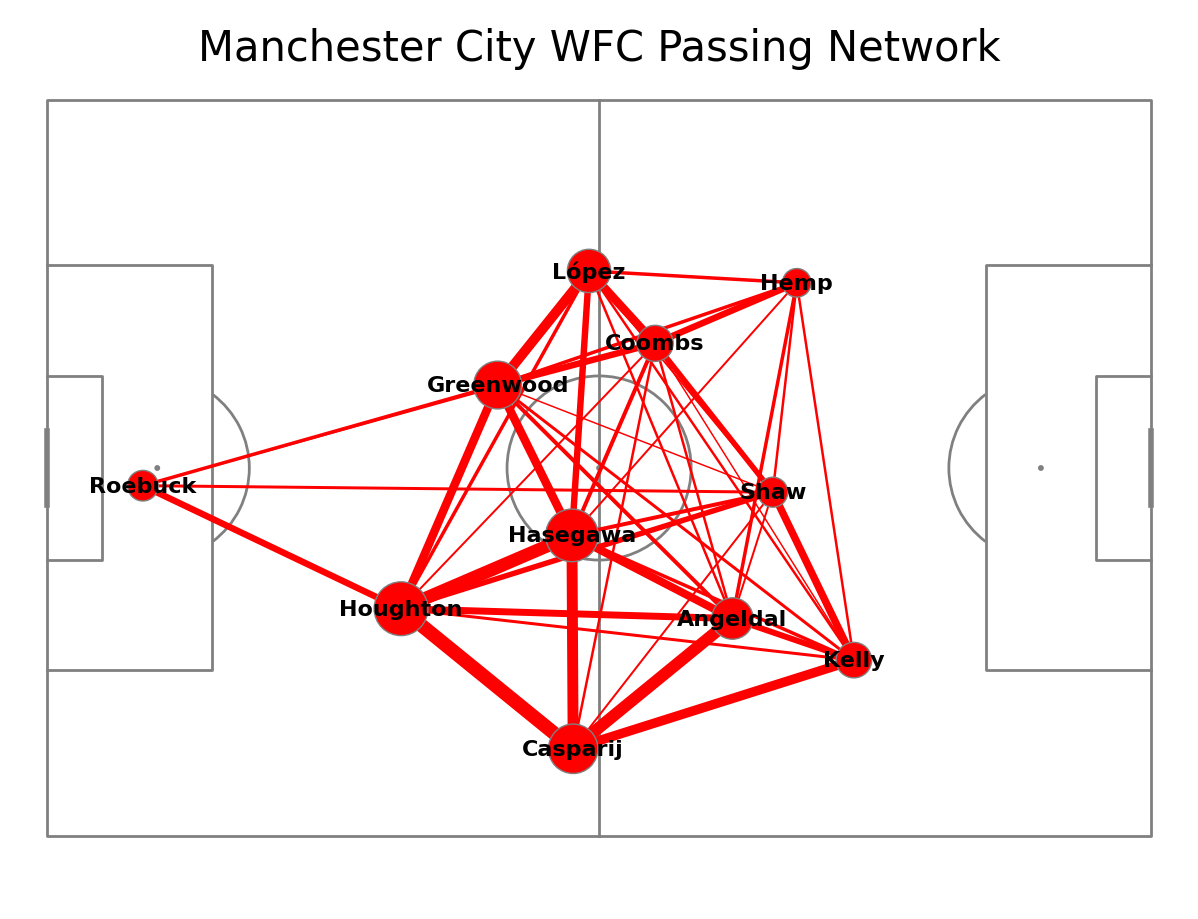

In [28]:
plotting_edges(home_dict)

In [29]:
# home team passing network
df_pass_away = prepare_data_pass(df,team_name=teams_comp[1])

df_pass_edges_away,lines_df_away,scatter_df_away = calculate_edges_width(df_pass_away)

away_dict = \
{
    'df_pass' : df_pass_away,
    'lines_df' : lines_df_away,
    'scatter_df' : scatter_df_away,
    'color': 'blue',
    'team_name' : teams_comp[1]
}

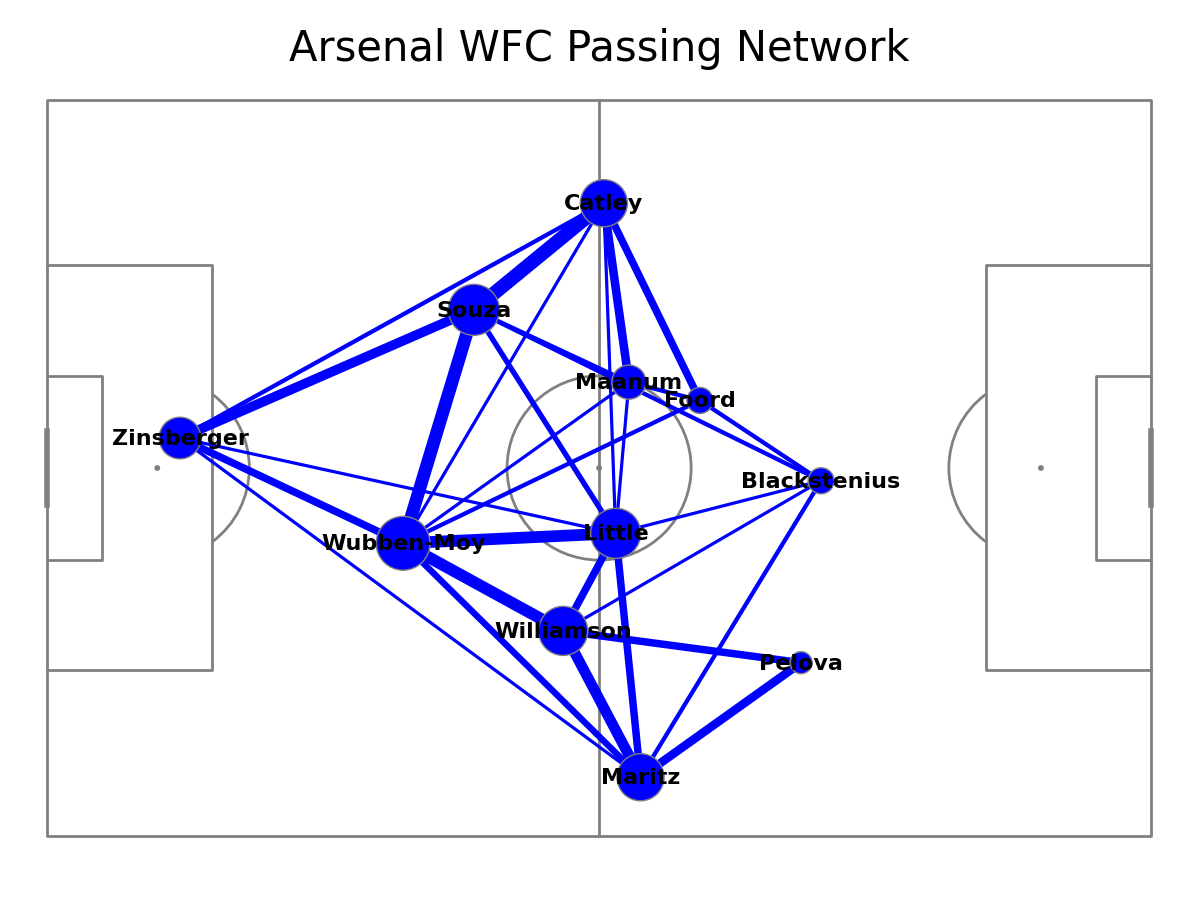

In [30]:
plotting_edges(away_dict)

## Centralisation
To calculate the centralisation index we need to calculate number of passes made by each player. 
Then, we calculate the denominator - the sum of all passes multiplied by (number of players - 1) -> 10
To calculate the numerator we sum the difference between maximal number of successful passes by 1 player
and number of successful passes by each player. We calculate the index dividing the numerator by denominator.

In [ ]:
#calculate number of successful passes by player
no_passes = df_pass.groupby(['player.name']).x.count().reset_index()
no_passes.rename({'x':'pass_count'}, axis='columns', inplace=True)
#find one who made most passes
max_no = no_passes["pass_count"].max() 
#calculate the denominator - 10*the total sum of passes
denominator = 10*no_passes["pass_count"].sum() 
#calculate the nominator
nominator = (max_no - no_passes["pass_count"]).sum()
#calculate the centralisation index
centralisation_index = nominator/denominator
print("Centralisation index is ", centralisation_index)

## Passing Network for Forward Passes

In [32]:
df_forward_passes_home = df_pass_home[df_pass_home['x']<df_pass_home['end_x']]

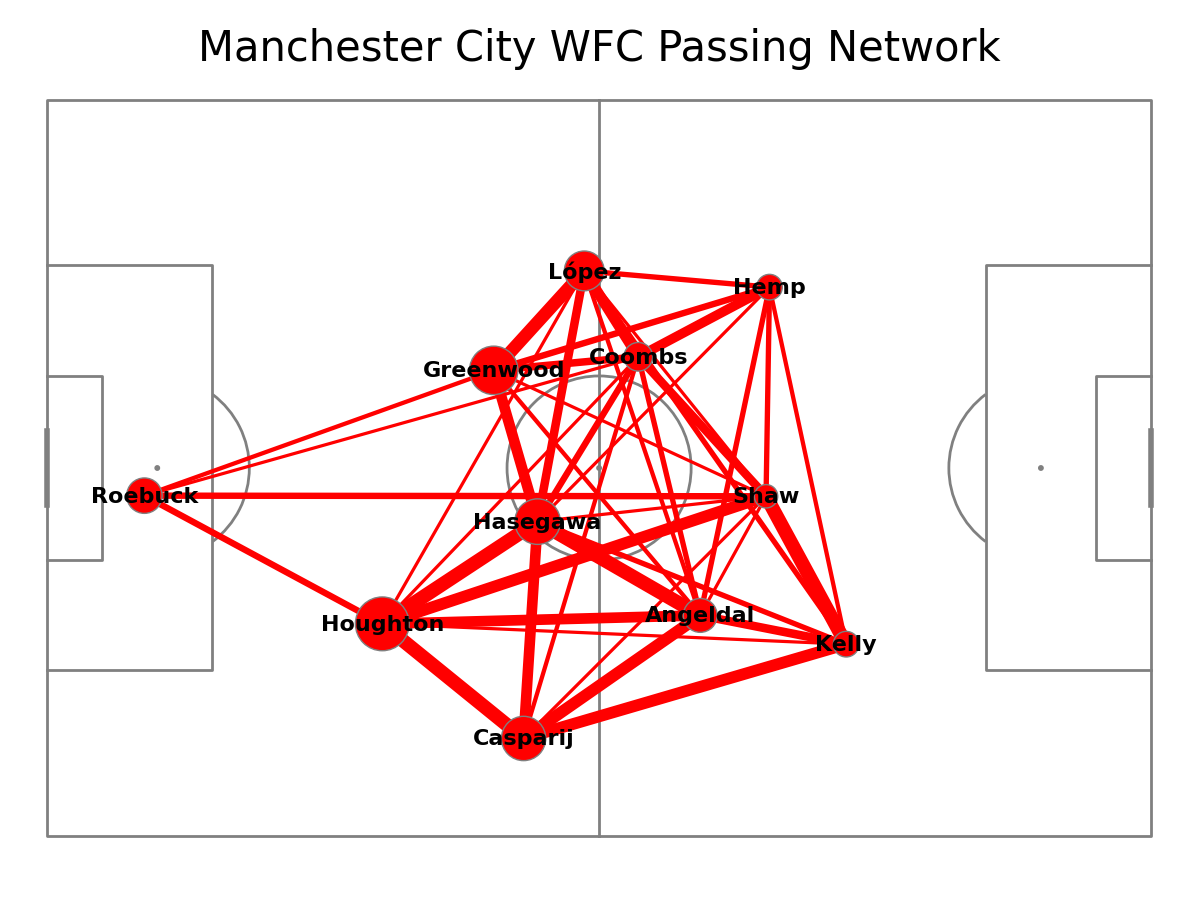

In [33]:
df_pass_edges_forward_home,lines_df_forward_home,scatter_df_forward_home = calculate_edges_width(df_forward_passes_home)

home_dict_forward = \
{
    'df_pass' : df_pass_edges_forward_home,
    'lines_df' : lines_df_forward_home,
    'scatter_df' : scatter_df_forward_home,
    'color': 'red',
    'team_name' : teams_comp[0]
}

plotting_edges(home_dict_forward)

In [35]:
df_forward_passes_away = df_pass_away[df_pass_away['x']<df_pass_away['end_x']]

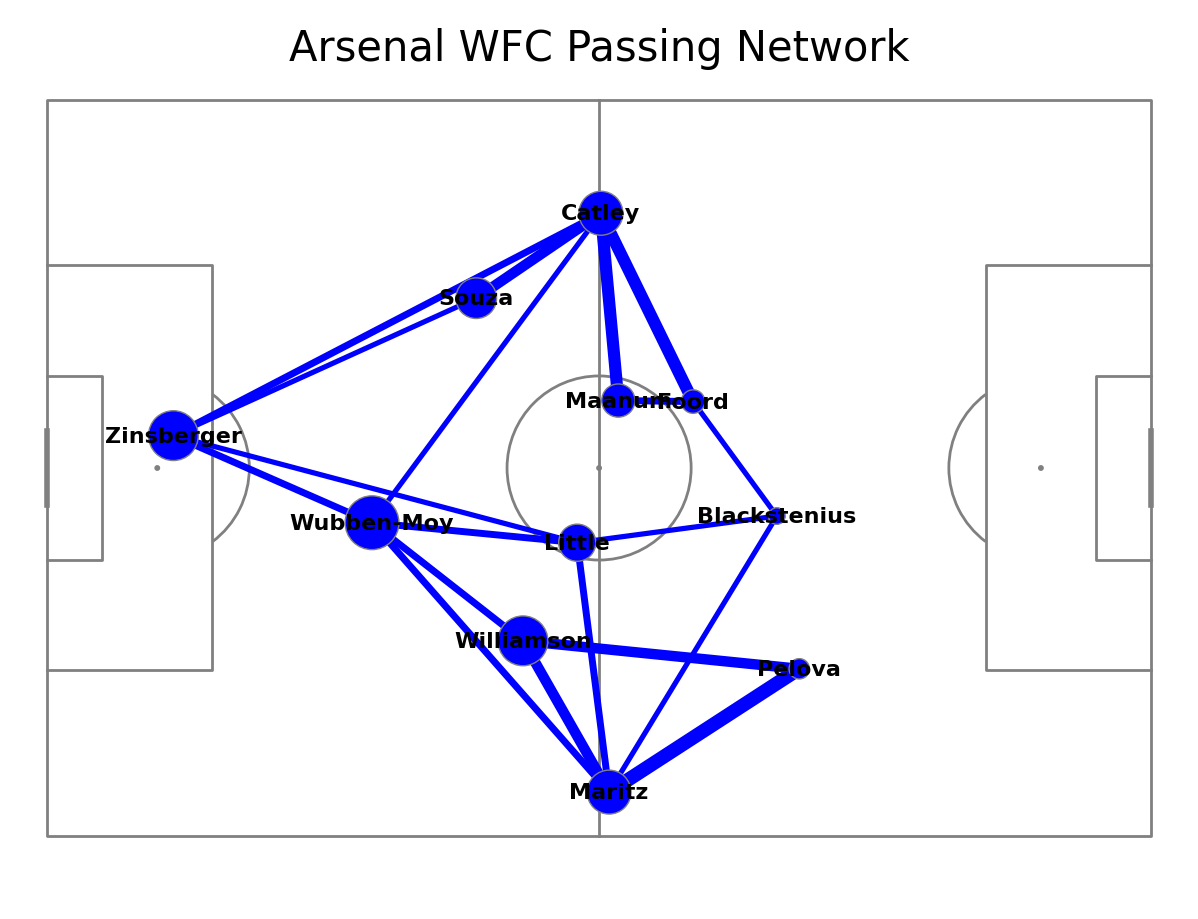

In [36]:
df_pass_edges_forward_away,lines_df_forward_away,scatter_df_forward_away = calculate_edges_width(df_forward_passes_away)

away_dict_forward = \
{
    'df_pass' : df_pass_edges_forward_away,
    'lines_df' : lines_df_forward_away,
    'scatter_df' : scatter_df_forward_away,
    'color': 'blue',
    'team_name' : teams_comp[1]
}

plotting_edges(away_dict_forward)